#Ансамблевые методы машинного обучения

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor,CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.datasets import make_classification,make_circles
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_circles,make_moons,make_regression,make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,mean_squared_error, mean_absolute_error,r2_score
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,BaggingClassifier, RandomForestClassifier,GradientBoostingRegressor, AdaBoostRegressor,GradientBoostingClassifier,AdaBoostClassifier

##Реализовать решение задач классификации и регрессии пользовательских и/или модельных данных с использованием бэггинга над деревьями решений и случайного леса

###Регрессия

In [ ]:
n_repeat = 50  # Количество итераций для вычисления
n_train = 50
n_test = 1000
noise = 0.1
np.random.seed(42)

estimators = [
    ("Дерево решений", DecisionTreeRegressor()),
    ("Бэггинг над деревом", BaggingRegressor(DecisionTreeRegressor())),
    ("Случайный лес",RandomForestRegressor())
]

n_estimators = len(estimators)

def f(x):
    x = x.ravel()
    return np.exp(-(x**2))/2 + 1.2 * np.exp(-((x + 3) ** 2))

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 -7
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y



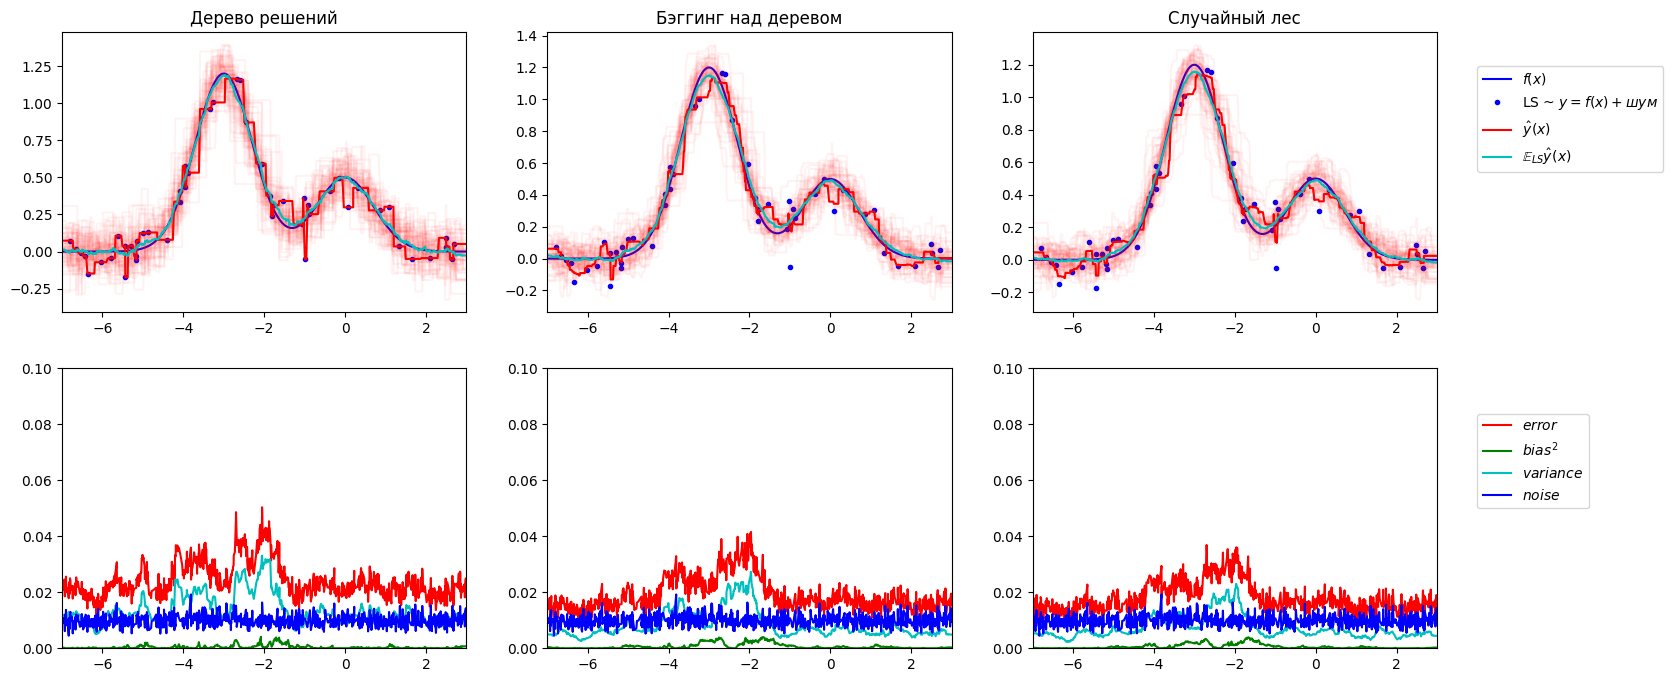

In [ ]:
X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

metriki_1 = {'Метрика': ['error', 'noise','bias^2', 'noise', 'MSE','MAE','r2 score'], }

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= n_repeat * n_repeat

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)
    mean_se = mean_squared_error(y_test,y_predict)
    mean_ae = mean_absolute_error(y_test,y_predict)
    r2_s = r2_score(y_test,y_predict)

    metriki_1[f"{name}"] = [
             np.mean(y_error),
             np.mean(y_noise),
             np.mean(y_bias),
             np.mean(y_var),
             mean_se,
             mean_ae,
             r2_s
          ]

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+шум$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c", label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-7, 3])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error$")
    plt.plot(X_test, y_bias, "g", label="$bias^2$"),
    plt.plot(X_test, y_var, "c", label="$variance$"),
    plt.plot(X_test, y_noise, "b", label="$noise$")

    plt.xlim([-7, 3])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

metriki_1 = pd.DataFrame(metriki_1)

plt.subplots_adjust(right=1.5)
plt.show()

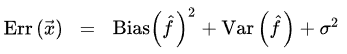

In [ ]:
metriki_1

,Метрика,Tree,Bagging(Tree),RandomForest
0,error,0.025137,0.020800,0.019003
1,noise,0.009771,0.009771,0.009771
2,bias^2,0.000411,0.000766,0.000812
3,noise,0.014766,0.010080,0.008240
4,MSE_sklearn,0.024997,0.020647,0.018912
5,MAE,0.124639,0.112496,0.108119
6,r2 score,0.848791,0.875108,0.885612


###Классификация

In [ ]:
def visualize_classifiers(X, y):
    plt.figure(figsize=(15, 5))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    classifiers = [
        ("Дерево решений", DecisionTreeClassifier()),
        ("Бэггинг над деревом", BaggingClassifier(DecisionTreeClassifier())),
        ("Случайный лес", RandomForestClassifier())
    ]

    for i, (name, clf) in enumerate(classifiers, 1):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        metriki_2[f"{name}"] = [
             accuracy,
             precision,
             recall,
             f1
          ]

        plt.subplot(1, len(classifiers), i)

        plot_decision_regions(X_test, y_test, clf=clf, legend=2)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(f'{name}')

    plt.tight_layout()
    plt.show()

####U-образные

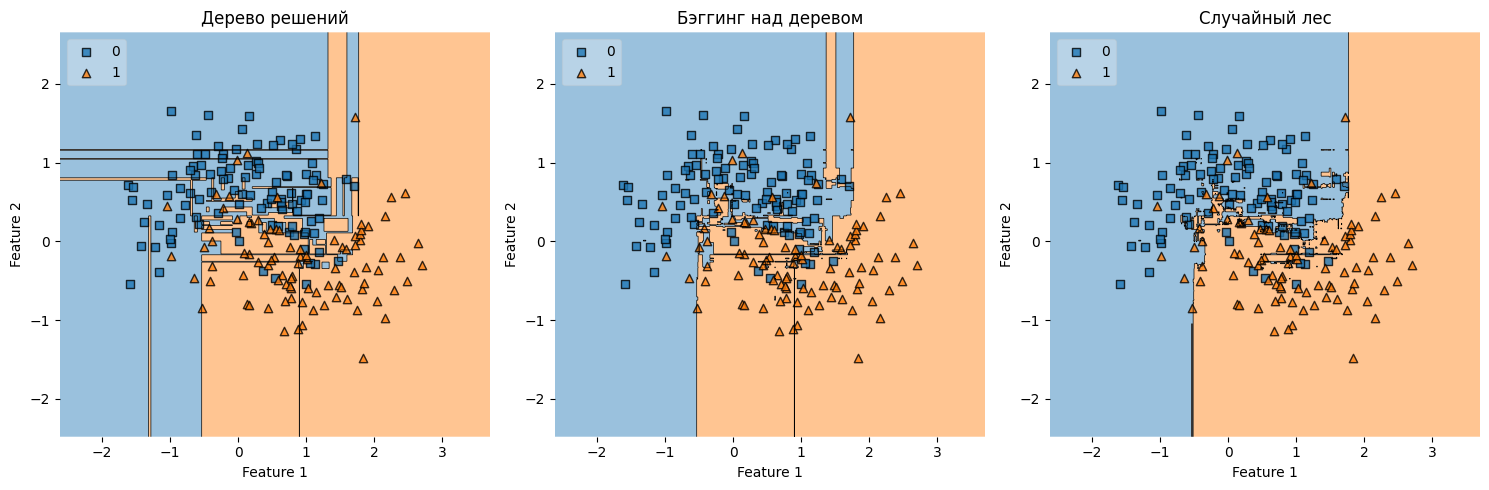

In [ ]:
np.random.seed(24)
X, y = make_moons(n_samples=1000, noise=0.40, random_state=24)
metriki_2 = {'Метрика': ['accuracy', 'precision','recall', 'f1 score'], }
visualize_classifiers(X, y)
metriki_2 = pd.DataFrame(metriki_2)

In [ ]:
metriki_2 = pd.DataFrame(metriki_2)

metriki_2

,Метрика,Дерево решений,Бэггинг над деревом,Случайный лес
0,accuracy,0.805000,0.830000,0.830000
1,precision,0.793478,0.847059,0.824176
2,recall,0.784946,0.774194,0.806452
3,f1 score,0.789189,0.808989,0.815217


####Окружности

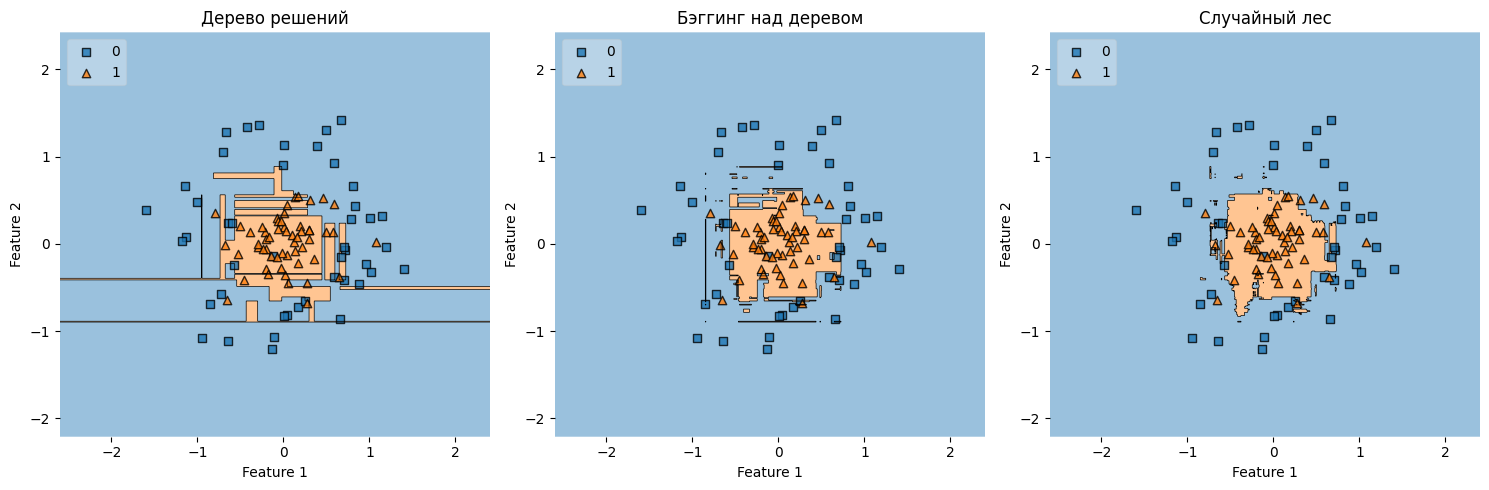

In [ ]:
np.random.seed(24)
X, y = make_circles(n_samples=500, factor=0.15, noise=0.3, random_state=24)


visualize_classifiers(X, y)

In [ ]:
metriki_2 = pd.DataFrame(metriki_2)

metriki_2

,Метрика,Дерево решений,Бэггинг над деревом,Случайный лес
0,accuracy,0.820000,0.850000,0.860000
1,precision,0.862745,0.900000,0.901961
2,recall,0.800000,0.818182,0.836364
3,f1 score,0.830189,0.857143,0.867925


####Линейные

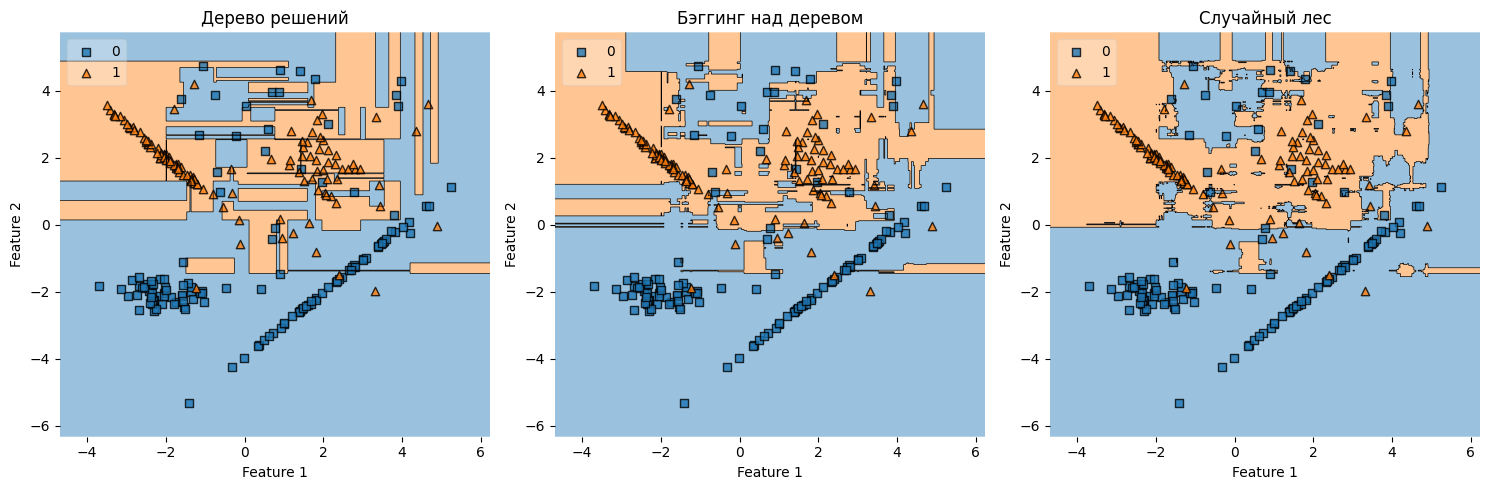

In [ ]:
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=2,
    weights=[0.5],
    flip_y=0,
    class_sep=2.0,
    random_state=24
)

outliers = np.random.rand(250, 2) * 7 - 2
outliers_labels = np.random.choice([0, 1], size=250, p=[0.65, 0.35])

X = np.vstack([X, outliers])
y = np.concatenate([y, outliers_labels])

visualize_classifiers(X, y)

In [ ]:
metriki_2 = pd.DataFrame(metriki_2)

metriki_2

,Метрика,Дерево решений,Бэггинг над деревом,Случайный лес
0,accuracy,0.904348,0.908696,0.917391
1,precision,0.928571,0.936937,0.923077
2,recall,0.881356,0.881356,0.915254
3,f1 score,0.904348,0.908297,0.919149


##Реализовать решение задач классификации и регрессии пользовательских и/или модельных данных с использованием градиентного бустинга, алгоритмов AdaBoost, XGBoost, CatBoost и LightGBM

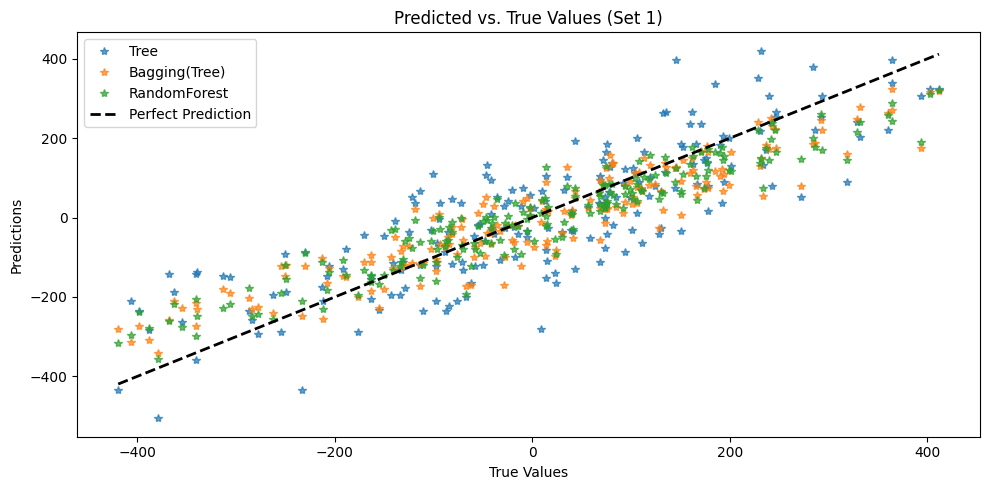

In [ ]:
# Создание синтетических данных для примера
X, y = make_regression(n_samples=1000, n_features=14, noise=0.15, random_state=24)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Определение списка оценщиков для первого набора графиков
estimators_set_ = [
    ("Tree", DecisionTreeRegressor()),
    ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor())),
    ("RandomForest", RandomForestRegressor())
]

# Сравнение оценщиков (первый набор графиков)
predictions_set1 = {}
metriki_1 = {'Метрика': ["Mean Squared Error", "Mean Absolute Error","R-squared"], }

for name, estimator in estimators_set_:
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metriki_1[f"{name}"] = [
             mse,
             mae,
             r2
          ]

    predictions_set1[name] = y_pred

# График предсказанных значений от реальных значений в виде кривых (первый набор графиков)
plt.figure(figsize=(10, 5))

for name, y_pred in predictions_set1.items():
    plt.plot(y_test, y_pred, label=name, marker='*', linestyle='', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs. True Values (Set 1)')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Определение списка оценщиков для второго набора графиков
estimators_set__ = [
    ("GradientBoosting", GradientBoostingRegressor()),
    ("AdaBoost", AdaBoostRegressor()),
    ("XGBoost", xgb.XGBRegressor()),
    ("CatBoost", CatBoostRegressor(silent=True)),
    ("LightGBM", lgb.LGBMRegressor())
]

# Сравнение оценщиков (второй набор графиков)
predictions_set2 = {}

for name, estimator in estimators_set__:
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metriki_1[f"{name}"] = [
             mse,
             mae,
             r2
          ]
    predictions_set2[name] = y_pred
metriki_1 = pd.DataFrame(metriki_1)
metriki_1
# График предсказанных значений от реальных значений в виде кривых (второй набор графиков)
plt.figure(figsize=(10, 5))

for name, y_pred in predictions_set2.items():
    plt.plot(y_test, y_pred, label=name, marker='*', linestyle='', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs. True Values (Set 2)')
plt.legend()

plt.tight_layout()
plt.show()

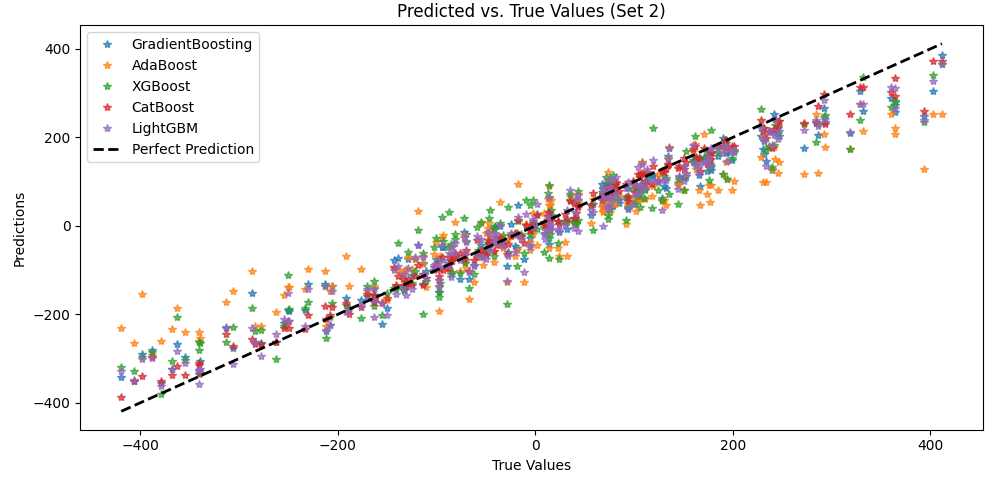

In [ ]:
metriki_1

,Метрика,Tree,Bagging(Tree),RandomForest,GradientBoosting,AdaBoost,XGBoost,CatBoost,LightGBM
0,Mean Squared Error,9305.263750,4800.335409,4184.440152,1948.556795,5927.655481,3114.542130,581.236739,1654.216754
1,Mean Absolute Error,78.436206,52.510990,51.569002,34.252030,60.260515,44.678279,16.791788,32.124665
2,R-squared,0.708519,0.849633,0.868925,0.938963,0.814320,0.902439,0.981793,0.948183


In [ ]:
metriki_2 = {'Метрика': ['Accuracy', 'Precision','Recall','F1 Score'], }

def visualize_classifiers(X, y):
    plt.figure(figsize=(15, 10))
    results = {'Method': [], 'Accuracy': [], 'Precision': [], 'Recall': [],'F1 Score': []}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    classifiers = [
      ("DecisionTree", DecisionTreeClassifier()),
      ("Bagging(Tree)", BaggingClassifier(DecisionTreeClassifier())),
      ("RandomForest", RandomForestClassifier()),
      ("GradientBoosting", GradientBoostingClassifier()),
      ("AdaBoost", AdaBoostClassifier()),
      ("XGBoost", xgb.XGBClassifier()),
      ("CatBoost", CatBoostClassifier(silent=True)),
      ("LightGBM", lgb.LGBMClassifier())
    ]

    for i, (name, clf) in enumerate(classifiers, 1):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        #plt.subplot(1, len(classifiers), i)
        plt.subplot(2, 4, i)
        plot_decision_regions(X_test, y_test, clf=clf, legend=2)
        plt.title(f'{name}\nAccuracy: {accuracy * 100:.2f}%')

        metriki_2[f"{name}"] = [
             accuracy,
             precision,
             recall,
             f1]

In [ ]:
np.random.seed(24)
X, y = make_moons(n_samples=1000, noise=0.40, random_state=24)

visualize_classifiers(X, y)

metriki_2 = pd.DataFrame(metriki_2)

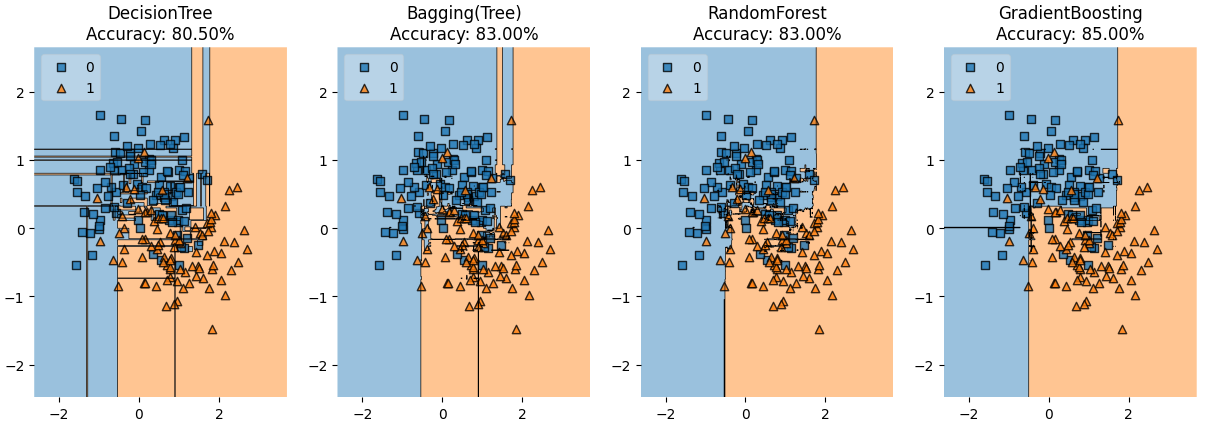

In [ ]:
metriki_2

,Метрика,DecisionTree,Bagging(Tree),RandomForest,GradientBoosting,AdaBoost,XGBoost,CatBoost,LightGBM
0,Accuracy,0.805000,0.830000,0.830000,0.850000,0.850000,0.830000,0.860000,0.840000
1,Precision,0.793478,0.847059,0.824176,0.818182,0.811881,0.817204,0.835052,0.821053
2,Recall,0.784946,0.774194,0.806452,0.870968,0.881720,0.817204,0.870968,0.838710
3,F1 Score,0.789189,0.808989,0.815217,0.843750,0.845361,0.817204,0.852632,0.829787


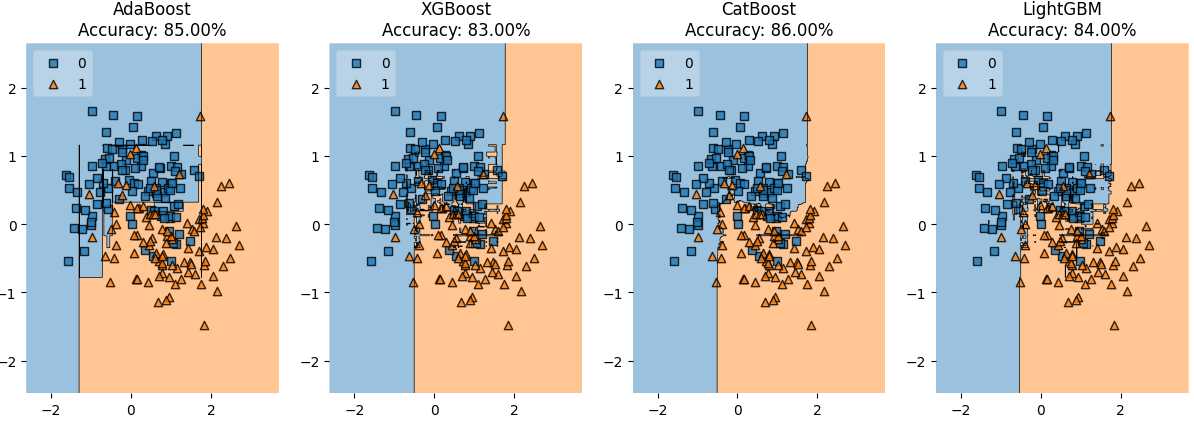

In [ ]:
np.random.seed(24)
X, y = make_circles(n_samples=500, factor=0.15, noise=0.3, random_state=24)


visualize_classifiers(X, y)

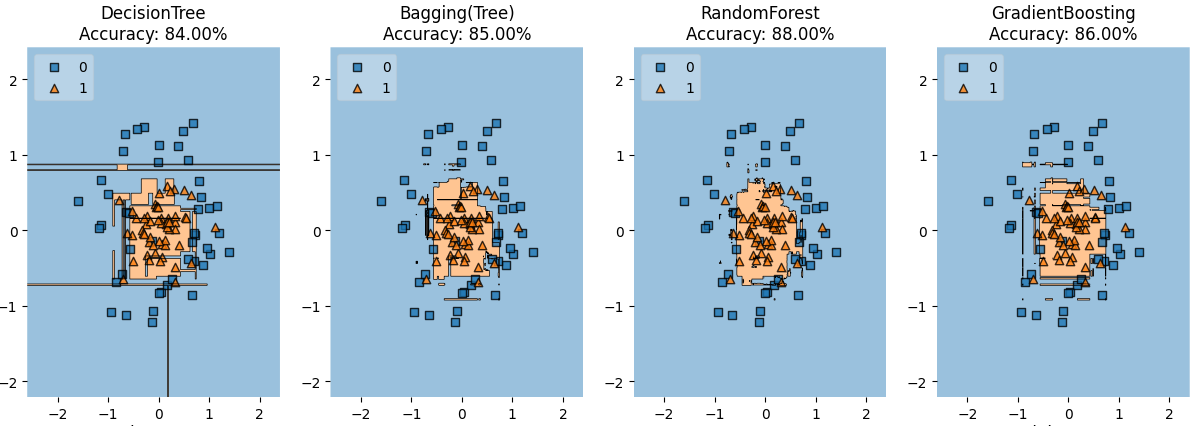

In [ ]:
metriki_2

,Метрика,DecisionTree,Bagging(Tree),RandomForest,GradientBoosting,AdaBoost,XGBoost,CatBoost,LightGBM
0,Accuracy,0.840000,0.850000,0.880000,0.860000,0.840000,0.840000,0.860000,0.840000
1,Precision,0.933333,0.976190,0.938776,0.918367,0.882353,0.882353,0.886792,0.882353
2,Recall,0.763636,0.745455,0.836364,0.818182,0.818182,0.818182,0.854545,0.818182
3,F1 Score,0.840000,0.845361,0.884615,0.865385,0.849057,0.849057,0.870370,0.849057


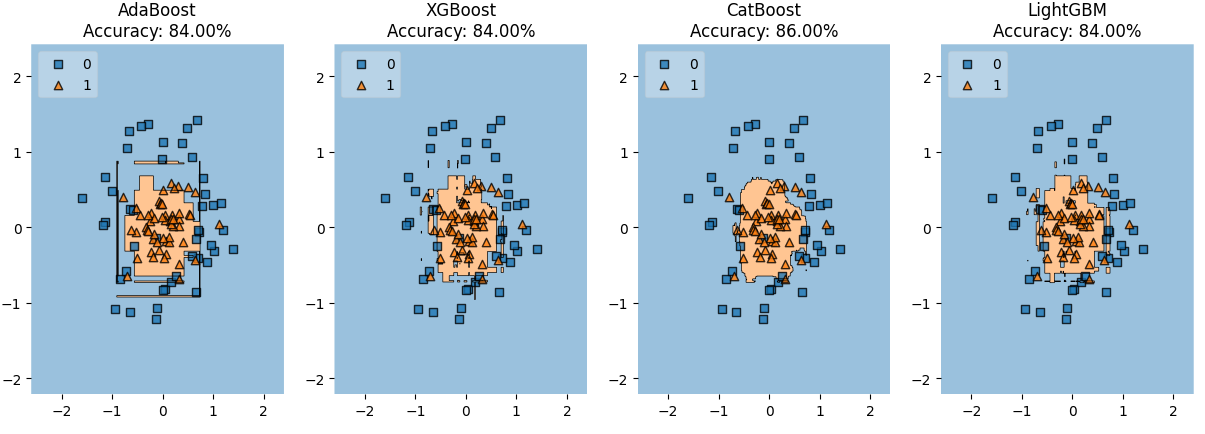

##Реализовать решение задач классификации и/или регрессии пользовательских и/или модельных данных с использованием стекинга.

In [ ]:
def visualize_classifiers(X, y):
    plt.figure(figsize=(15, 15))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    classifiers = [
      ("KNN_5", KNeighborsClassifier(n_neighbors=5)),
      ("KNN_10", KNeighborsClassifier(n_neighbors=10)),
      ("KNN_15", KNeighborsClassifier(n_neighbors=15)),
      ("SVM", SVC()),
      ("DecisionTree", DecisionTreeClassifier()),
      ("Bagging(Tree)", BaggingClassifier(DecisionTreeClassifier())),
      ("RandomForest", RandomForestClassifier()),
      ("GradientBoosting", GradientBoostingClassifier()),
      ("AdaBoost", AdaBoostClassifier()),
      ("XGBoost", xgb.XGBClassifier()),
      ("CatBoost", CatBoostClassifier(silent=True)),
      ("LightGBM", lgb.LGBMClassifier())
    ]

    for i, (name, clf) in enumerate(classifiers, 1):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        metriki_1[f"{name}"] = [
                            accuracy,
                            precision,
                            recall,
                            f1
                              ]

        #plt.subplot(1, len(classifiers), i)
        plt.subplot(3, 4, i)
        plot_decision_regions(X_test, y_test, clf=clf, legend=2)
        plt.title(f'{name}\nAccuracy: {accuracy * 100:.2f}%')



    # Визуализация стекинга
    stacking_model = StackingClassifier(
        #classifiers=[clf for name, clf in classifiers],
        estimators=[(name, clf) for name, clf in classifiers],
        #meta_classifier=LogisticRegression()
        final_estimator=LogisticRegression()
    )
    stacking_model.fit(X_train, y_train)
    y_pred_stacking = stacking_model.predict(X_test)

    accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
    precision_stacking = precision_score(y_test, y_pred_stacking)
    recall_stacking = recall_score(y_test, y_pred_stacking)
    f1_stacking = f1_score(y_test, y_pred_stacking)

    metriki_1[f"stacking"] = [
                        accuracy_stacking,
                        precision_stacking,
                        recall_stacking,
                        f1_stacking]

    plt.figure()
    plot_decision_regions(X_test, y_test, clf=stacking_model, legend=2)
    plt.title(f'Stacking\nAccuracy: {accuracy_stacking * 100:.2f}%')



In [ ]:
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=2,
    weights=[0.5],
    flip_y=0,
    class_sep=2.0,
    random_state=24
)

outliers = np.random.rand(250, 2) * 7 - 2
outliers_labels = np.random.choice([0, 1], size=250, p=[0.65, 0.35])

X = np.vstack([X, outliers])
y = np.concatenate([y, outliers_labels])

metriki_1 = {'Метрика': ['accuracy', 'precision','recall', 'f1 score'], }

# Визуализация классификаторов и стекинга
visualize_classifiers(X, y)

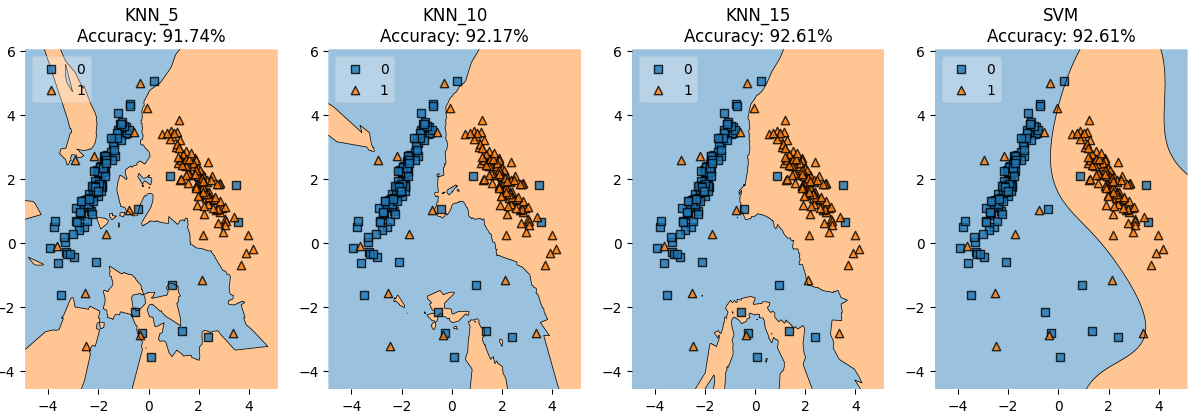

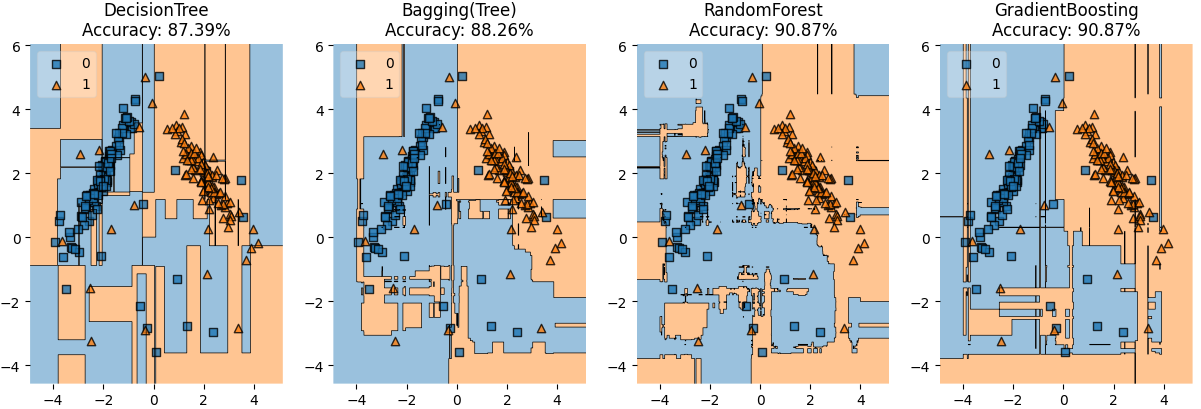

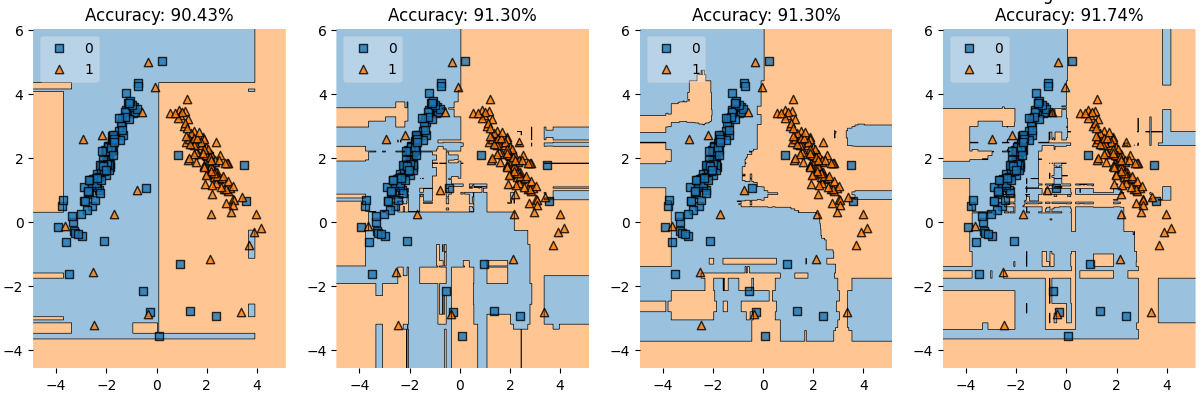

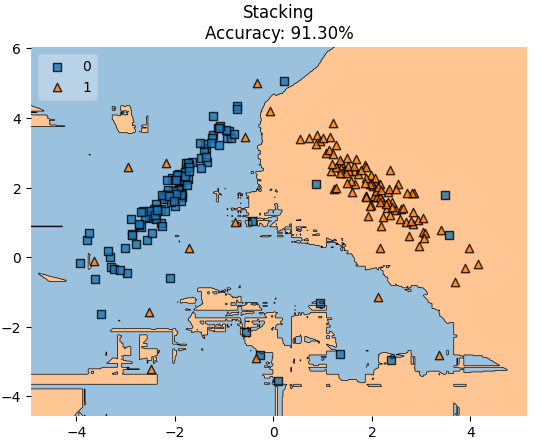

In [ ]:
metriki_1 = pd.DataFrame(metriki_1)

In [ ]:
metriki_1

,Метрика,KNN_5,KNN_10,KNN_15,SVM,DecisionTree,Bagging(Tree),RandomForest,GradientBoosting,AdaBoost,XGBoost,CatBoost,LightGBM,stacking
0,accuracy,0.917391,0.921739,0.926087,0.926087,0.873913,0.882609,0.908696,0.908696,0.904348,0.913043,0.913043,0.917391,0.913043
1,precision,0.910714,0.942857,0.935185,0.960784,0.872727,0.896226,0.924528,0.909091,0.915888,0.909910,0.917431,0.918182,0.925234
2,recall,0.918919,0.891892,0.909910,0.882883,0.864865,0.855856,0.882883,0.900901,0.882883,0.909910,0.900901,0.909910,0.891892
3,f1 score,0.914798,0.916667,0.922374,0.920188,0.868778,0.875576,0.903226,0.904977,0.899083,0.909910,0.909091,0.914027,0.908257


In [ ]:
np.random.seed(24)
X, y = make_circles(n_samples=500, factor=0.15, noise=0.3, random_state=24)


visualize_classifiers(X, y)


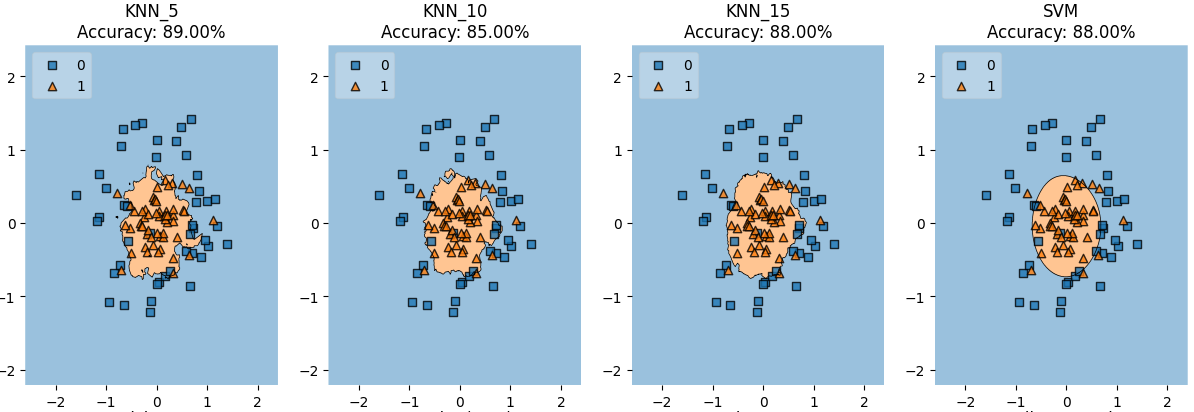

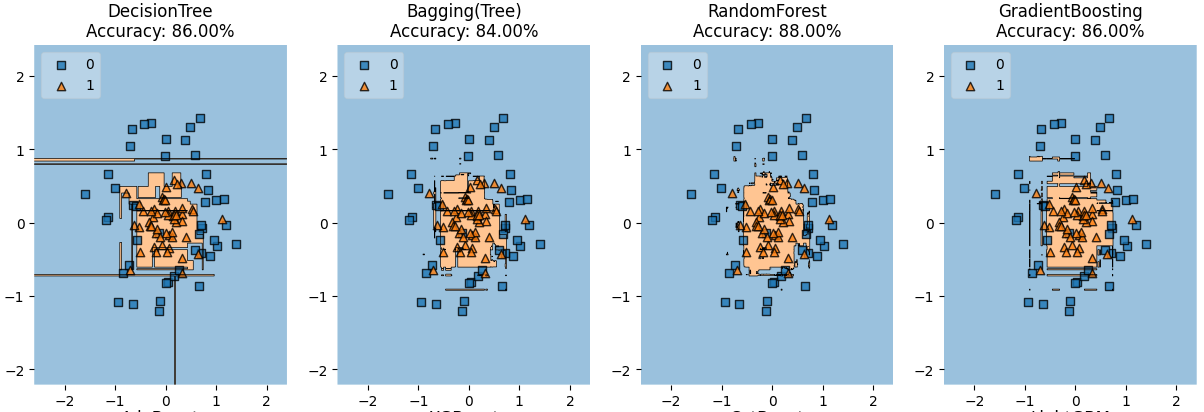

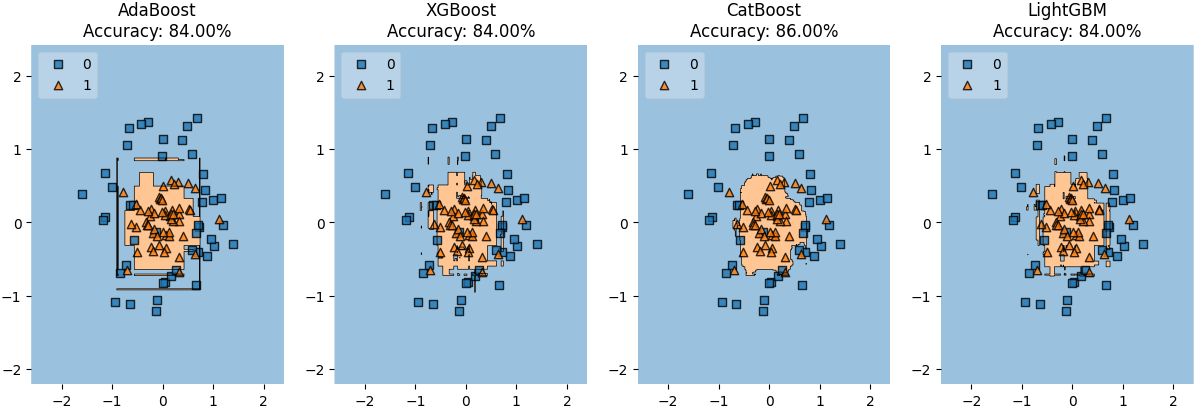

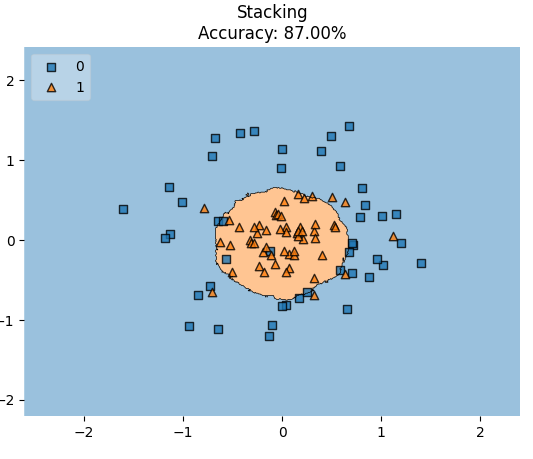

In [ ]:
metriki_1 = pd.DataFrame(metriki_1)

In [ ]:
metriki_1

,Метрика,KNN_5,KNN_10,KNN_15,SVM,DecisionTree,Bagging(Tree),RandomForest,GradientBoosting,AdaBoost,XGBoost,CatBoost,LightGBM,stacking
0,accuracy,0.890000,0.850000,0.880000,0.880000,0.860000,0.840000,0.880000,0.860000,0.840000,0.840000,0.860000,0.840000,0.870000
1,precision,0.923077,0.870370,0.890909,0.905660,0.976744,0.975610,0.938776,0.918367,0.882353,0.882353,0.886792,0.882353,0.903846
2,recall,0.872727,0.854545,0.890909,0.872727,0.763636,0.727273,0.836364,0.818182,0.818182,0.818182,0.854545,0.818182,0.854545
3,f1 score,0.897196,0.862385,0.890909,0.888889,0.857143,0.833333,0.884615,0.865385,0.849057,0.849057,0.870370,0.849057,0.878505


In [ ]:
np.random.seed(24)
X, y = make_moons(n_samples=1000, noise=0.40, random_state=24)

visualize_classifiers(X, y)


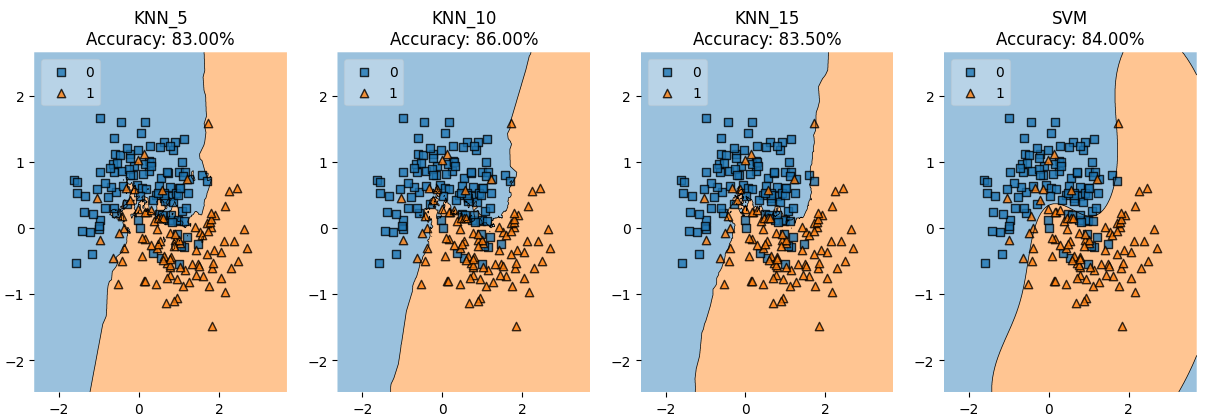

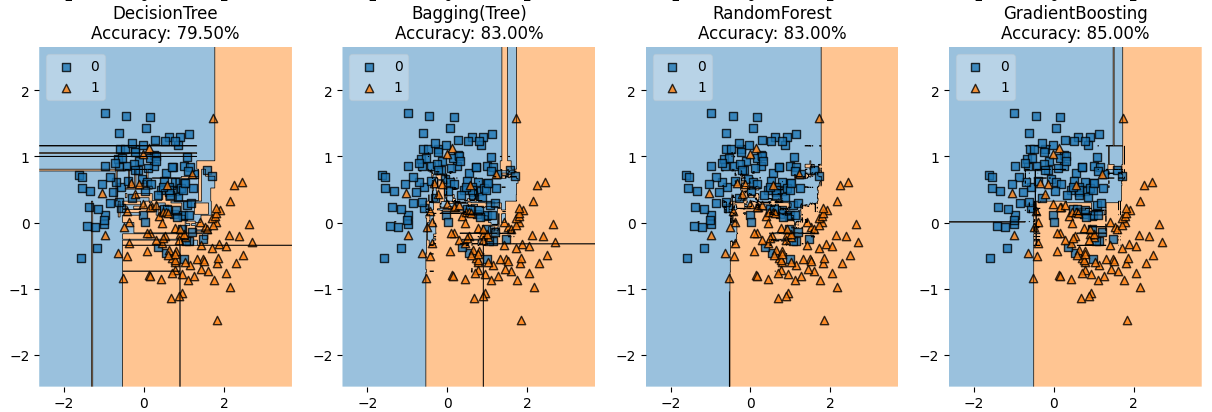

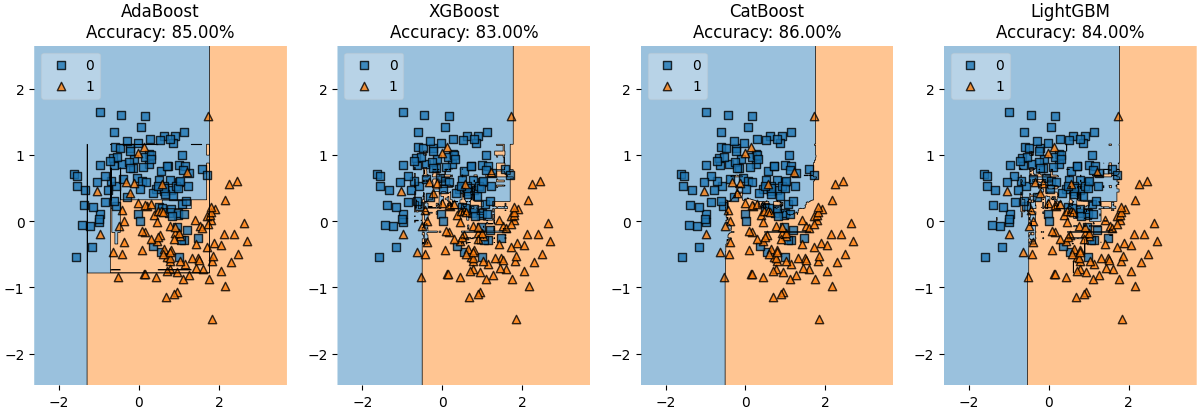

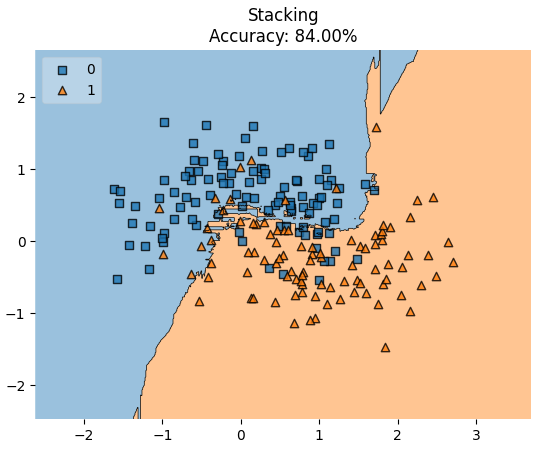

In [ ]:
metriki_1 = pd.DataFrame(metriki_1)

In [ ]:
metriki_1

,Метрика,KNN_5,KNN_10,KNN_15,SVM,DecisionTree,Bagging(Tree),RandomForest,GradientBoosting,AdaBoost,XGBoost,CatBoost,LightGBM,stacking
0,accuracy,0.830000,0.860000,0.835000,0.840000,0.795000,0.830000,0.830000,0.850000,0.850000,0.830000,0.860000,0.840000,0.840000
1,precision,0.817204,0.857143,0.800000,0.808081,0.782609,0.831461,0.824176,0.818182,0.811881,0.817204,0.835052,0.821053,0.801980
2,recall,0.817204,0.838710,0.860215,0.860215,0.774194,0.795699,0.806452,0.870968,0.881720,0.817204,0.870968,0.838710,0.870968
3,f1 score,0.817204,0.847826,0.829016,0.833333,0.778378,0.813187,0.815217,0.843750,0.845361,0.817204,0.852632,0.829787,0.835052


###Регрессия

In [ ]:
# Создание синтетических данных для примера
X, y = make_regression(n_samples=500, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

metriki_1 = {'Метрика': ['mse', 'mae','r2'], }
# Определение списка оценщиков для первого набора графиков
estimators_set1 = [
    ("Tree", DecisionTreeRegressor()),
    ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor())),
    ("RandomForest", RandomForestRegressor())
]

# Сравнение оценщиков (первый набор графиков)
results_set1 = {"Method": [], "Mean Squared Error": [], "Mean Absolute Error": [], "R-squared": []}
predictions_set1 = {}

for name, estimator in estimators_set1:
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metriki_1[f"{name}"] = [
             mse,
             mae,
             r2
          ]

    predictions_set1[name] = y_pred

# Определение списка оценщиков для второго набора графиков
estimators_set2 = [
    ("GradientBoosting", GradientBoostingRegressor()),
    ("AdaBoost", AdaBoostRegressor()),
    ("XGBoost", xgb.XGBRegressor()),
    ("CatBoost", CatBoostRegressor(silent=True)),
    ("LightGBM", lgb.LGBMRegressor())
]

# Сравнение оценщиков (второй набор графиков)
results_set2 = {"Method": [], "Mean Squared Error": [], "Mean Absolute Error": [], "R-squared": []}
predictions_set2 = {}

for name, estimator in estimators_set2:
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metriki_1[f"{name}"] = [
             mse,
             mae,
             r2
          ]

    predictions_set2[name] = y_pred

# Модель для первого уровня стекинга
meta_model_set1 = StackingRegressor(
    estimators=[(name, estimator) for name, estimator in estimators_set1],
    final_estimator=LinearRegression()
)

# Обучение модели для первого уровня
meta_model_set1.fit(X_train, y_train)
y_pred_stacking_set1 = meta_model_set1.predict(X_test)

metriki_1[f"Первый уровень стекинга"] = [
             (mean_squared_error(y_test, y_pred_stacking_set1)),
             (mean_absolute_error(y_test, y_pred_stacking_set1)),
             (r2_score(y_test, y_pred_stacking_set1))
          ]

predictions_set1["Stacking_trees"] = y_pred_stacking_set1

# Модель для второго уровня стекинга
meta_model_set2 = StackingRegressor(
    estimators=[(name, estimator) for name, estimator in estimators_set2],
    final_estimator=LinearRegression()
)

# Обучение модели для второго уровня
meta_model_set2.fit(X_train, y_train)
y_pred_stacking_set2 = meta_model_set2.predict(X_test)

metriki_1[f"Второй уровень стекинга"] = [
             (mean_squared_error(y_test, y_pred_stacking_set2)),
             (mean_absolute_error(y_test, y_pred_stacking_set2)),
             (r2_score(y_test, y_pred_stacking_set2)) ]

predictions_set2["Stacking_boost"] = y_pred_stacking_set2

# Преобразование результатов в DataFrame
metriki_1 = pd.DataFrame(metriki_1)
results_df_set2 = pd.DataFrame(results_set2)

# График предсказанных значений от реальных значений в виде кривых для первого набора графиков
plt.figure(figsize=(10, 5))

for name, y_pred in predictions_set1.items():
    plt.plot(y_test, y_pred, label=name, marker='o', linestyle='', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs. True Values (Set 1)')
plt.legend()

plt.tight_layout()
plt.show()

# График предсказанных значений от реальных значений в виде кривых для второго набора графиков
plt.figure(figsize=(10, 5))

for name, y_pred in predictions_set2.items():
    plt.plot(y_test, y_pred, label=name, marker='o', linestyle='', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs. True Values (Set 2)')
plt.legend()

plt.tight_layout()
plt.show()

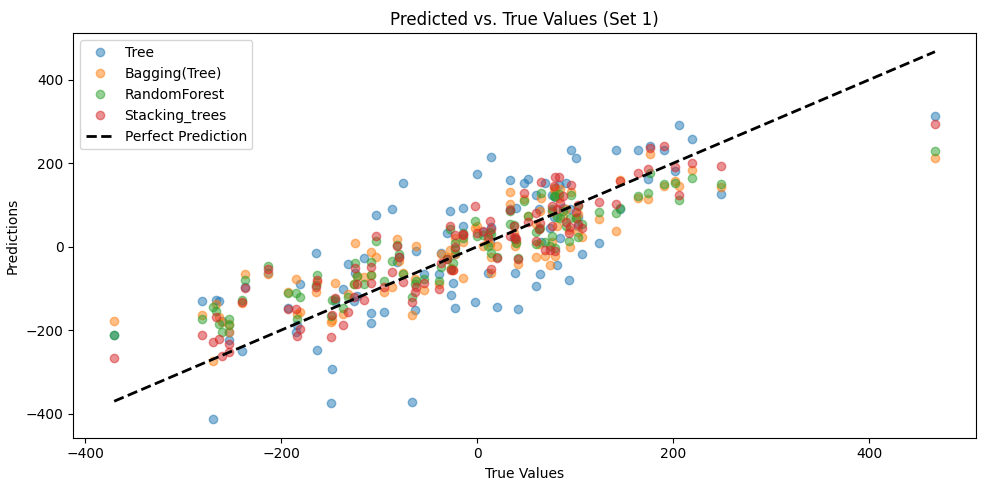

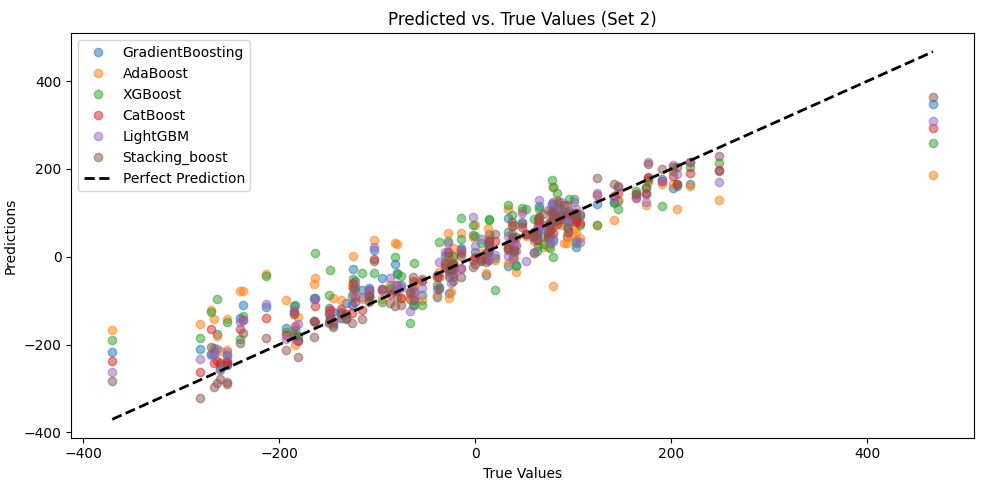

In [ ]:
metriki_1 = pd.DataFrame(metriki_1)

In [ ]:
metriki_1

,Метрика,Tree,Bagging(Tree),RandomForest,GradientBoosting,AdaBoost,XGBoost,CatBoost,LightGBM,Первый уровень стекинга,Второй уровень стекинга
0,mse,9563.845348,5092.404130,4155.157479,2243.343398,5812.257289,4320.275996,1298.138486,1921.020962,3391.786256,824.984048
1,mae,79.402068,54.706051,49.646200,36.905240,57.830431,50.192965,22.837588,32.597490,45.504157,21.884256
2,r2,0.516167,0.742376,0.789791,0.886510,0.705959,0.781438,0.934327,0.902816,0.828410,0.958264


##Реализовать решение задач классификации и/или регрессии пользовательских и/или модельных данных с использованием многоуровнего стекинга.

In [ ]:
np.random.seed(24)
X, y = make_circles(n_samples=500, factor=0.15, noise=0.3, random_state=24)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
metriki_1 = {'Метрика': ['accuracy', 'precision','recall','f1'], }
classifiers = [
      ("KNN_5", KNeighborsClassifier(n_neighbors=5)),
      ("KNN_10", KNeighborsClassifier(n_neighbors=10)),
      ("KNN_15", KNeighborsClassifier(n_neighbors=15)),
      ("SVM", SVC()),
      ("DecisionTree", DecisionTreeClassifier()),
      ("Bagging(Tree)", BaggingClassifier(DecisionTreeClassifier())),
      ("RandomForest", RandomForestClassifier()),
      ("GradientBoosting", GradientBoostingClassifier()),
      ("AdaBoost", AdaBoostClassifier()),
      ("XGBoost", xgb.XGBClassifier()),
      ("CatBoost", CatBoostClassifier(silent=True)),
      ("LightGBM", lgb.LGBMClassifier())
    ]


meta_model = StackingClassifier(
    estimators=[
        ("RandomForest", RandomForestClassifier()),
        ("CatBoost", CatBoostClassifier(silent=True)),
        ("LightGBM", lgb.LGBMClassifier())
    ],
    final_estimator=LogisticRegression()
)

multi_level_stack_model = StackingClassifier(
        estimators=[(name, clf) for name, clf in classifiers],
        final_estimator=meta_model
    )


multi_level_stack_model.fit(X_train, y_train)
y_pred_stacking = multi_level_stack_model.predict(X_test)

accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
precision_stacking = precision_score(y_test, y_pred_stacking)
recall_stacking = recall_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)

metriki_1[f"Многоуровневый стекинг"] = [
             accuracy_stacking,
             precision_stacking,
             recall_stacking,
             f1_stacking]

plt.figure()
plot_decision_regions(X_test, y_test, clf=multi_level_stack_model, legend=2)
plt.title(f'Multi_level_Stacking\nAccuracy: {accuracy_stacking * 100:.2f}%')


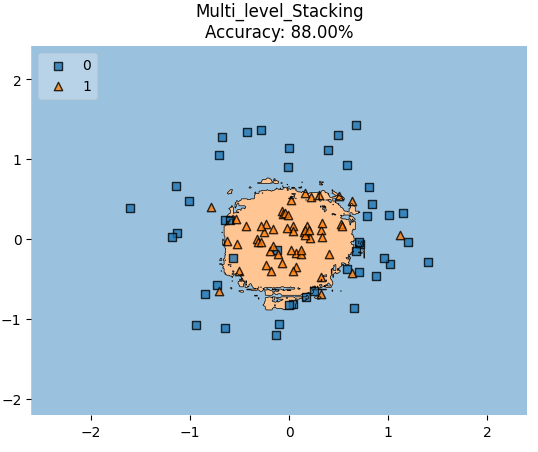

In [ ]:
metriki_1 = pd.DataFrame(metriki_1)

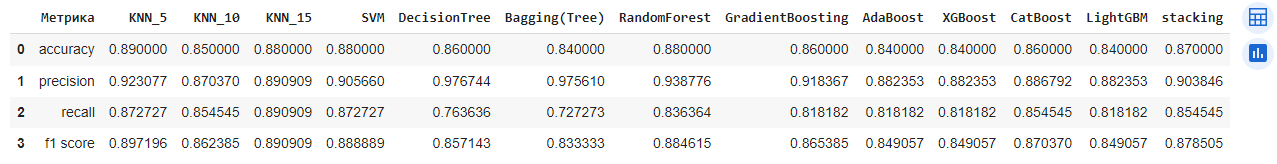

In [ ]:
metriki_1

,Метрика,Многоуровневый стекинг
0,accuracy,0.880000
1,precision,0.905660
2,recall,0.872727
3,f1,0.888889


In [ ]:
np.random.seed(24)
X, y = make_moons(n_samples=1000, noise=0.40, random_state=24)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

classifiers = [
      ("KNN_5", KNeighborsClassifier(n_neighbors=5)),
      ("KNN_10", KNeighborsClassifier(n_neighbors=10)),
      ("KNN_15", KNeighborsClassifier(n_neighbors=15)),
      ("SVM", SVC()),
      ("DecisionTree", DecisionTreeClassifier()),
      ("Bagging(Tree)", BaggingClassifier(DecisionTreeClassifier())),
      ("RandomForest", RandomForestClassifier()),
      ("GradientBoosting", GradientBoostingClassifier()),
      ("AdaBoost", AdaBoostClassifier()),
      ("XGBoost", xgb.XGBClassifier()),
      ("CatBoost", CatBoostClassifier(silent=True)),
      ("LightGBM", lgb.LGBMClassifier())
    ]


meta_model = StackingClassifier(
    estimators=[
        ("RandomForest", RandomForestClassifier()),
        ("CatBoost", CatBoostClassifier(silent=True)),
        ("LightGBM", lgb.LGBMClassifier())
    ],
    final_estimator=LogisticRegression()
)

multi_level_stack_model = StackingClassifier(
        estimators=[(name, clf) for name, clf in classifiers],
        final_estimator=meta_model
    )


multi_level_stack_model.fit(X_train, y_train)
y_pred_stacking = multi_level_stack_model.predict(X_test)

accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
precision_stacking = precision_score(y_test, y_pred_stacking)
recall_stacking = recall_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)

metriki_1[f"Многоуровневый стекинг"] = [
             accuracy_stacking,
             precision_stacking,
             recall_stacking,
             f1_stacking]

plt.figure()
plot_decision_regions(X_test, y_test, clf=multi_level_stack_model, legend=2)
plt.title(f'Multi_level_Stacking\nAccuracy: {accuracy_stacking * 100:.2f}%')


plt.tight_layout()
plt.show()

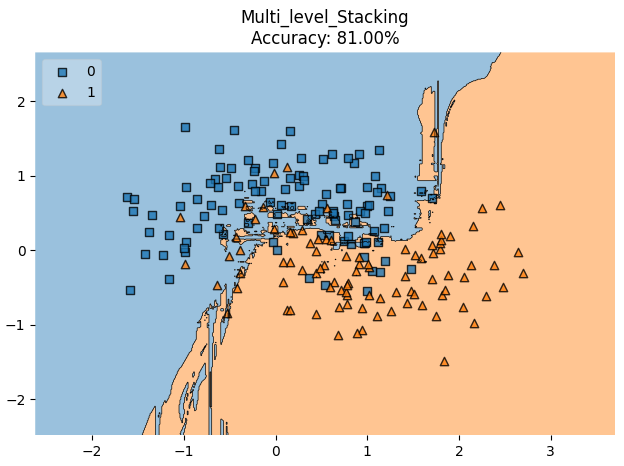

In [ ]:
metriki_1 = pd.DataFrame(metriki_1)

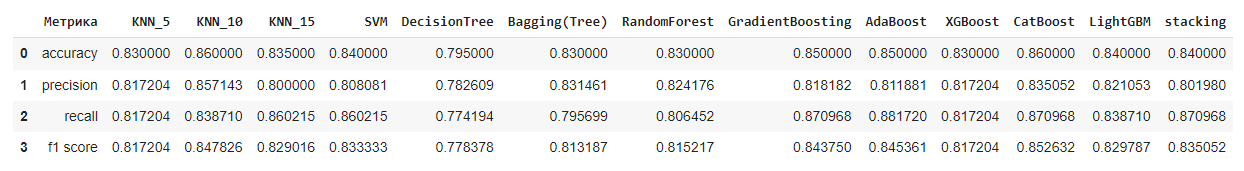

In [ ]:
metriki_1

,Метрика,Многоуровневый стекинг
0,accuracy,0.810000
1,precision,0.772277
2,recall,0.838710
3,f1,0.804124


In [ ]:
np.random.seed(24)

X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=2,
    weights=[0.5],
    flip_y=0,
    class_sep=2.0,
    random_state=24
)

outliers = np.random.rand(250, 2) * 7 - 2
outliers_labels = np.random.choice([0, 1], size=250, p=[0.65, 0.35])

X = np.vstack([X, outliers])
y = np.concatenate([y, outliers_labels])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

classifiers = [
      ("KNN_5", KNeighborsClassifier(n_neighbors=5)),
      ("KNN_10", KNeighborsClassifier(n_neighbors=10)),
      ("KNN_15", KNeighborsClassifier(n_neighbors=15)),
      ("SVM", SVC()),
      ("DecisionTree", DecisionTreeClassifier()),
      ("Bagging(Tree)", BaggingClassifier(DecisionTreeClassifier())),
      ("RandomForest", RandomForestClassifier()),
      ("GradientBoosting", GradientBoostingClassifier()),
      ("AdaBoost", AdaBoostClassifier()),
      ("XGBoost", xgb.XGBClassifier()),
      ("CatBoost", CatBoostClassifier(silent=True)),
      ("LightGBM", lgb.LGBMClassifier())
    ]


meta_model = StackingClassifier(
    estimators=[
        ("RandomForest", RandomForestClassifier()),
        ("CatBoost", CatBoostClassifier(silent=True)),
        ("LightGBM", lgb.LGBMClassifier())
    ],
    final_estimator=LogisticRegression()
)

multi_level_stack_model = StackingClassifier(
        estimators=[(name, clf) for name, clf in classifiers],
        final_estimator=meta_model
    )


multi_level_stack_model.fit(X_train, y_train)
y_pred_stacking = multi_level_stack_model.predict(X_test)

accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
precision_stacking = precision_score(y_test, y_pred_stacking)
recall_stacking = recall_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)

metriki_1[f"Многоуровневый стекинг"] = [
             accuracy_stacking,
             precision_stacking,
             recall_stacking,
             f1_stacking]

plt.figure()
plot_decision_regions(X_test, y_test, clf=multi_level_stack_model, legend=2)
plt.title(f'Multi_level_Stacking\nAccuracy: {accuracy_stacking * 100:.2f}%')

plt.tight_layout()
plt.show()

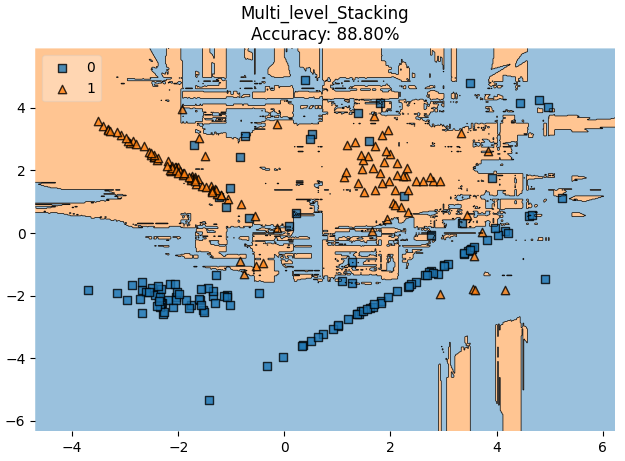

In [ ]:
metriki_1 = pd.DataFrame(metriki_1)

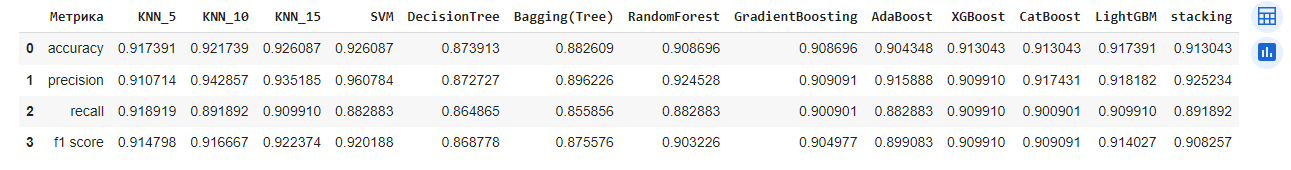

In [ ]:
metriki_1

,Метрика,Многоуровневый стекинг
0,accuracy,0.888000
1,precision,0.864000
2,recall,0.907563
3,f1,0.885246
